In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.tools.measurements import ent_entropy , diag_ensemble
from numpy.random import ranf, seed
from joblib import delayed, Parallel
import numpy as np
from time import time

In [2]:
n_real = 20
n_jobs = 2

In [3]:
L = 10
Jxy = 1.0
Jzz_0 = 1.0
h_MBL = 3.9
h_ETH = 0.1
vs = np.logspace(-2.0,0.0,num=20,base = 10)

In [4]:
v = 1
def ramp(t):
    return (0.5 + v*t)
ramp_args = []

In [5]:
basis = spin_basis_1d(L, Nup = L//2, pauli = False)
Jzz = [[Jzz_0,i,i+1] for i in range(L-1)]
Jxy = [[Jxy/2.0, i , i+1] for i in range(L-1)]
static = [["+-",Jxy],["-+",Jxy]]
dynamic = [["zz", Jzz, ramp,ramp_args]]
H_XXZ = hamiltonian(static, dynamic, basis = basis, dtype = np.float64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [6]:
def _do_ramp(psi_0,H,basis,v,E_final,V_final):
 """
    Auxiliary function to evolve the state and calculate the entropies after the ramp.
    --- arguments ---
    psi_0: initial state
    H: time-dependent Hamiltonian
    basis: spin_basis_1d object containing the spin basis (required for Sent)
    E_final, V_final: eigensystem of H(t_f) at the end of the ramp t_f=1/(2v)
 """
 t_f = 0.5/v
 psi = H.evolve(psi_0, 0.0,t_f)
 subsys = range(basis.L//2) # define subsystem
 Sent = ent_entropy(psi,basis,chain_subsys=subsys)["Sent"]
 S_d = diag_ensemble(basis.L,psi,E_final,V_final,Sd_Renyi=True)["Sd_pure"]
 return np.asarray([S_d,Sent])

In [7]:
def realization(vs, H_XXZ, basis, real):
    """
     This function computes the entropies for a single disorder realisation.
     --- arguments ---
     vs: vector of ramp speeds
     H_XXZ: time-dep. Heisenberg Hamiltonian with driven zz-interactions
     basis: spin_basis_1d object containing the spin basis
     n_real: number of disorder realisations; used only for timing
    """
    ti = time()
    global v
    seed()
    unscaled_fields = -1 + 2*ranf((basis.L,))
    h_z = [[unscaled_fields[i],i] for i in range(basis.L)]
    disorder_field = [["z",h_z]]
    no_checks = {"check_herm":False, "check_pcon":False, "check_symm":False}
    Hz = hamiltonian(disorder_field, [], basis = basis, dtype = np.float64, **no_checks)
    H_MBL = H_XXZ + h_MBL*Hz
    H_ETH = H_XXZ + h_ETH*Hz

    v = 1.0
    eigsh_args = {"k":2, "which":"BE", "maxiter":1E4, "return_eigenvectors":False}
    Emin, Emax = H_MBL.eigsh(time = 0.0, **eigsh_args)
    E_inf_temp = (Emax + Emin)/2.0

    E, psi_0 = H_MBL.eigsh(time = 0.0, k=1, sigma = E_inf_temp, maxiter = 1E4)
    psi_0 = psi_0.reshape((-1,))
    E_final, V_final = H_MBL.eigh(time = (0.5/vs[-1]))
    run_MBL=[_do_ramp(psi_0,H_MBL,basis,v,E_final,V_final) for v in vs]
    run_MBL=np.vstack(run_MBL).T

    v=1.0
    
    Emin,Emax=H_ETH.eigsh(time= 0.0,**eigsh_args)
    E_inf_temp=(Emax+Emin)/2.0
    
    E,psi_0=H_ETH.eigsh(time= 0.0,k=1,sigma=E_inf_temp,maxiter=1E4)
    psi_0=psi_0.reshape((-1,))
    
    E_final,V_final=H_ETH.eigh(time=( 0.5/vs[-1]))
    
    run_ETH=[_do_ramp(psi_0,H_ETH,basis,v,E_final,V_final) for v in vs]
    run_ETH=np.vstack(run_ETH).T 

    print("realization {0}/{1} took {2:.2f} sec".format(real+1,n_real,time()-ti))
    return run_MBL,run_ETH

In [8]:
##### produce data for n_real disorder realisations #####
# __name__ == ’__main__’ required to use joblib in Windows.
if __name__ == '__main__':

    """
    # alternative way without parallelisation
    data = np.asarray([realization(vs,H_XXZ,basis,i) for i in range(n_real)])
    """
    data = np.asarray(Parallel(n_jobs=n_jobs)(delayed(realization)(vs,H_XXZ,basis,i) for i in range(n_real)))
    run_MBL,run_ETH = zip(*data) # extract MBL and data
    mean_MBL = np.mean(run_MBL,axis= 0)
    mean_ETH = np.mean(run_ETH,axis= 0)

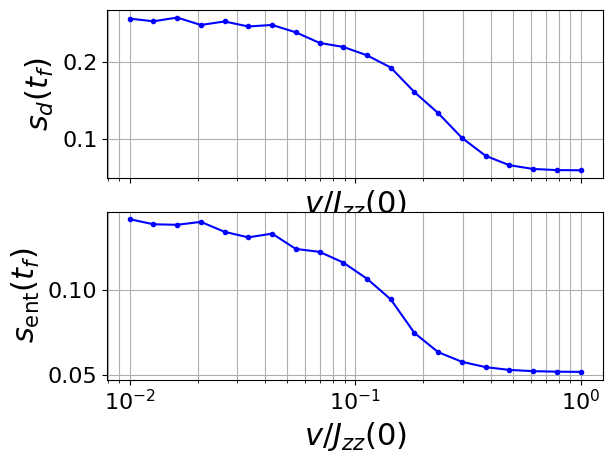

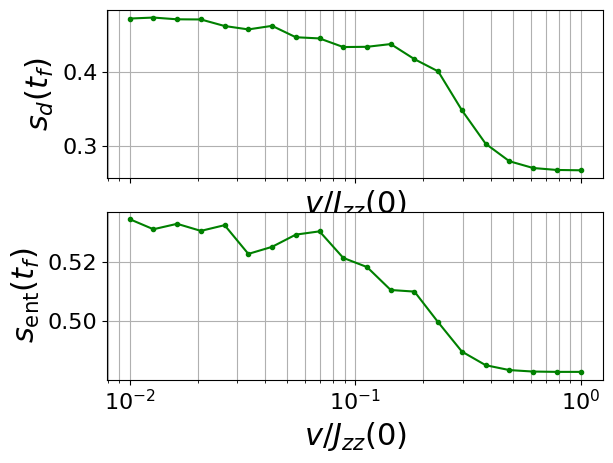

In [9]:
import matplotlib.pyplot as plt
 ### MBL plot ###
fig, pltarr1 = plt.subplots(2,sharex=True) # define subplot panel
 # subplot 1: diag enetropy vs ramp speed
pltarr1[ 0].plot(vs,mean_MBL[ 0],label="MBL",marker=".",color="blue") # plot
data
pltarr1[ 0].set_ylabel("$s_d(t_f)$",fontsize=22) # label y-axis
pltarr1[ 0].set_xlabel("$v/J_{zz}( 0)$",fontsize=22) # label x-axis
pltarr1[ 0].set_xscale("log") # set log scale on x-axis
pltarr1[ 0].grid(True,which='both') # plot grid
pltarr1[ 0].tick_params(labelsize=16)
 # subplot 2: entanglement entropy vs ramp speed
pltarr1[1].plot(vs,mean_MBL[1],marker=".",color="blue") # plot data
pltarr1[1].set_ylabel("$s_\mathrm{ent}(t_f)$",fontsize=22) # label y-axis
pltarr1[1].set_xlabel("$v/J_{zz}( 0)$",fontsize=22) # label x-axis
pltarr1[1].set_xscale("log") # set log scale on x-axis
pltarr1[1].grid(True,which='both') # plot grid
pltarr1[1].tick_params(labelsize=16)
 # save figure
# fig.savefig('example1_MBL.pdf', bbox_inches='tight')
 #
 ### ETH plot ###
fig, pltarr2 = plt.subplots(2,sharex=True) # define subplot panel
 # subplot 1: diag enetropy vs ramp speed
pltarr2[ 0].plot(vs,mean_ETH[ 0],marker=".",color="green") # plot data
pltarr2[ 0].set_ylabel("$s_d(t_f)$",fontsize=22) # label y-axis
pltarr2[ 0].set_xlabel("$v/J_{zz}( 0)$",fontsize=22) # label x-axis
pltarr2[ 0].set_xscale("log") # set log scale on x-axis
pltarr2[ 0].grid(True,which='both') # plot grid
pltarr2[ 0].tick_params(labelsize=16)
# subplot 2: entanglement entropy vs ramp speed
pltarr2[1].plot(vs,mean_ETH[1],marker=".",color="green") # plot data
pltarr2[1].set_ylabel("$s_\mathrm{ent}(t_f)$",fontsize=22) # label y-axis
pltarr2[1].set_xlabel("$v/J_{zz}( 0)$",fontsize=22) # label x-axis
pltarr2[1].set_xscale("log") # set log scale on x-axis
pltarr2[1].grid(True,which='both') # plot grid
pltarr2[1].tick_params(labelsize=16)
# save figure
# fig.savefig('example1_ETH.pdf', bbox_inches='tight')
#
plt.show() # show plots